# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [4]:
from olist.order import Order

orders = Order().get_training_data()
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,15.0,0.0,delivered,0.0,0.0,4.0,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,19.0,0.0,delivered,0.0,0.0,4.0,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,26.0,0.0,delivered,1.0,0.0,5.0,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.0,26.0,0.0,delivered,1.0,0.0,5.0,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.0,12.0,0.0,delivered,1.0,0.0,5.0,1,1,19.90,8.72


In [5]:
# from olist.data import Olist
# from olist.seller import Seller

# order_items = Olist().get_data()["order_items"]
# order_items = order_items.drop(
#     columns=["order_item_id", "shipping_limit_date", "price", "freight_value"]
# )

# sellers = (
#     Seller()
#     .get_training_data()
#     .merge(
#         orders.merge(order_items, on="order_id")
#         .assign(
#             review_cost=lambda _df: _df["review_score"].map(
#                 {1: 100, 2: 50, 3: 40, 4: 0, 5: 0}
#             )
#         )
#         .drop_duplicates()
#         .loc[:, ["order_id", "seller_id", "review_cost"]]
#         .groupby("seller_id")
#         .sum(),
#         on="seller_id",
#     )
#     .rename(columns={"review_cost": "cost_of_reviews"})
#     .assign(
#         revenue=lambda _df: _df["sales"] * 0.1 + _df["months_on_olist"] * 80),
#         profits=lambda _df: _df["revenue"] - _df["cost_of_reviews"]
# )

In [6]:
from olist.seller import Seller
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenue,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


In [7]:
sellers.profits.sum()/1_000_000

1.167608444

In [8]:
sellers.shape

(2967, 18)

In [9]:
print(sellers.cost_of_reviews.mean())
print(sellers.revenue.mean())

545.4027637344119
938.93442669363


### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

In [10]:
def calculate_it_cost(df, n_sellers=None):
    if n_sellers:
        n_sellers = n_sellers
    else:
        n_sellers = len(df)
    n_items = df["quantity"].sum()

    alpha = 3157.27
    beta = 978.23

    it_cost = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

    return it_cost

def calculate_total_profits(df, n_sellers=None):
    it_cost = calculate_it_cost(df, n_sellers)

    total_profit = df["profits"].sum()

    overall_profit = total_profit - it_cost
    return overall_profit

In [11]:
calculate_total_profits(sellers)

667609.1254806706

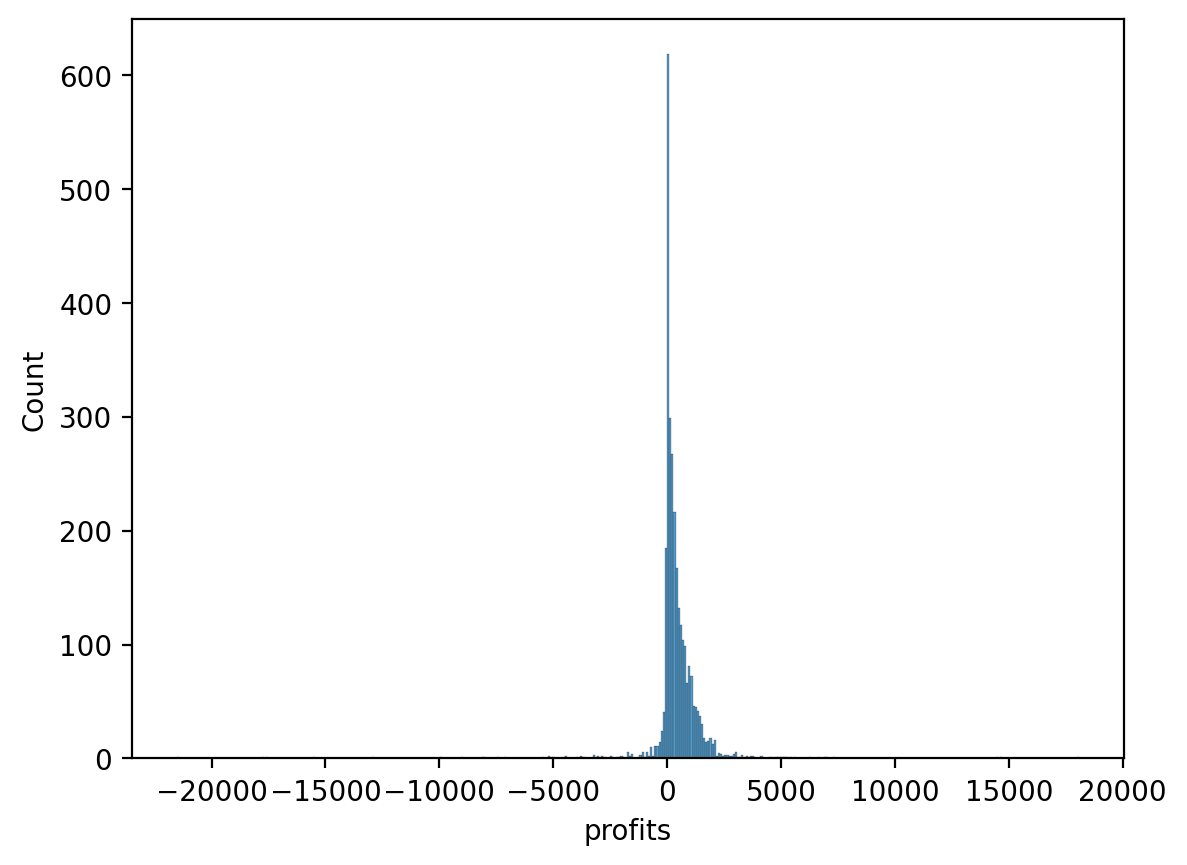

In [12]:
import seaborn as sns

%config InlineBackend.figure_format = "retina"

g = sns.histplot(data=sellers, x="profits")

In [13]:
least_profitable_sellers = sellers.sort_values("profits", ascending=True).reset_index()
least_profitable_sellers.head(100)

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenue,profits
0,769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,0.124729,0.514100,3.937093,35290,1854,2033,1.096548,123304.83,13770.483,-21519.517
1,2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,3.827873,39400,1806,1987,1.100221,200472.92,21647.292,-17752.708
2,1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,4.077586,29530,1706,1775,1.040445,104288.42,11948.842,-17581.158
3,945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,0.113935,0.527607,3.997371,20220,1146,1203,1.049738,37177.52,4677.752,-15542.248
4,315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118211,0.568690,4.074547,15440,943,1018,1.079533,17535.69,2553.569,-12886.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2192,99a54764c341d5dc80b4a8fac4eba3fb,sao paulo,SP,0.0,7.078411,2018-04-27 21:30:29,2018-08-28 16:05:19,4.0,0.159091,0.386364,3.613636,1130,45,67,1.488889,3708.76,690.876,-439.124
96,852,95f83f51203c626648c875dd41874c7f,borda da mata,MG,0.0,11.095884,2017-11-24 16:33:43,2018-08-22 03:55:13,9.0,0.207547,0.490566,3.622642,1470,52,67,1.288462,3217.46,1041.746,-428.254
97,464,002100f778ceb8431b7a1020ff7ab48f,franca,SP,0.0,16.192371,2017-09-14 01:10:15,2018-04-12 13:11:45,7.0,0.134615,0.519231,3.903846,1110,51,55,1.078431,1234.50,683.450,-426.550
98,2061,c9aafcd0621b2207c10e32c649cada4d,sao paulo,SP,0.0,9.011923,2018-07-14 21:35:19,2018-08-12 12:25:11,1.0,0.181818,0.568182,4.022727,800,44,52,1.181818,2997.25,379.725,-420.275


In [14]:
baseline_profit = calculate_total_profits(sellers)
baseline_profit

667609.1254806706

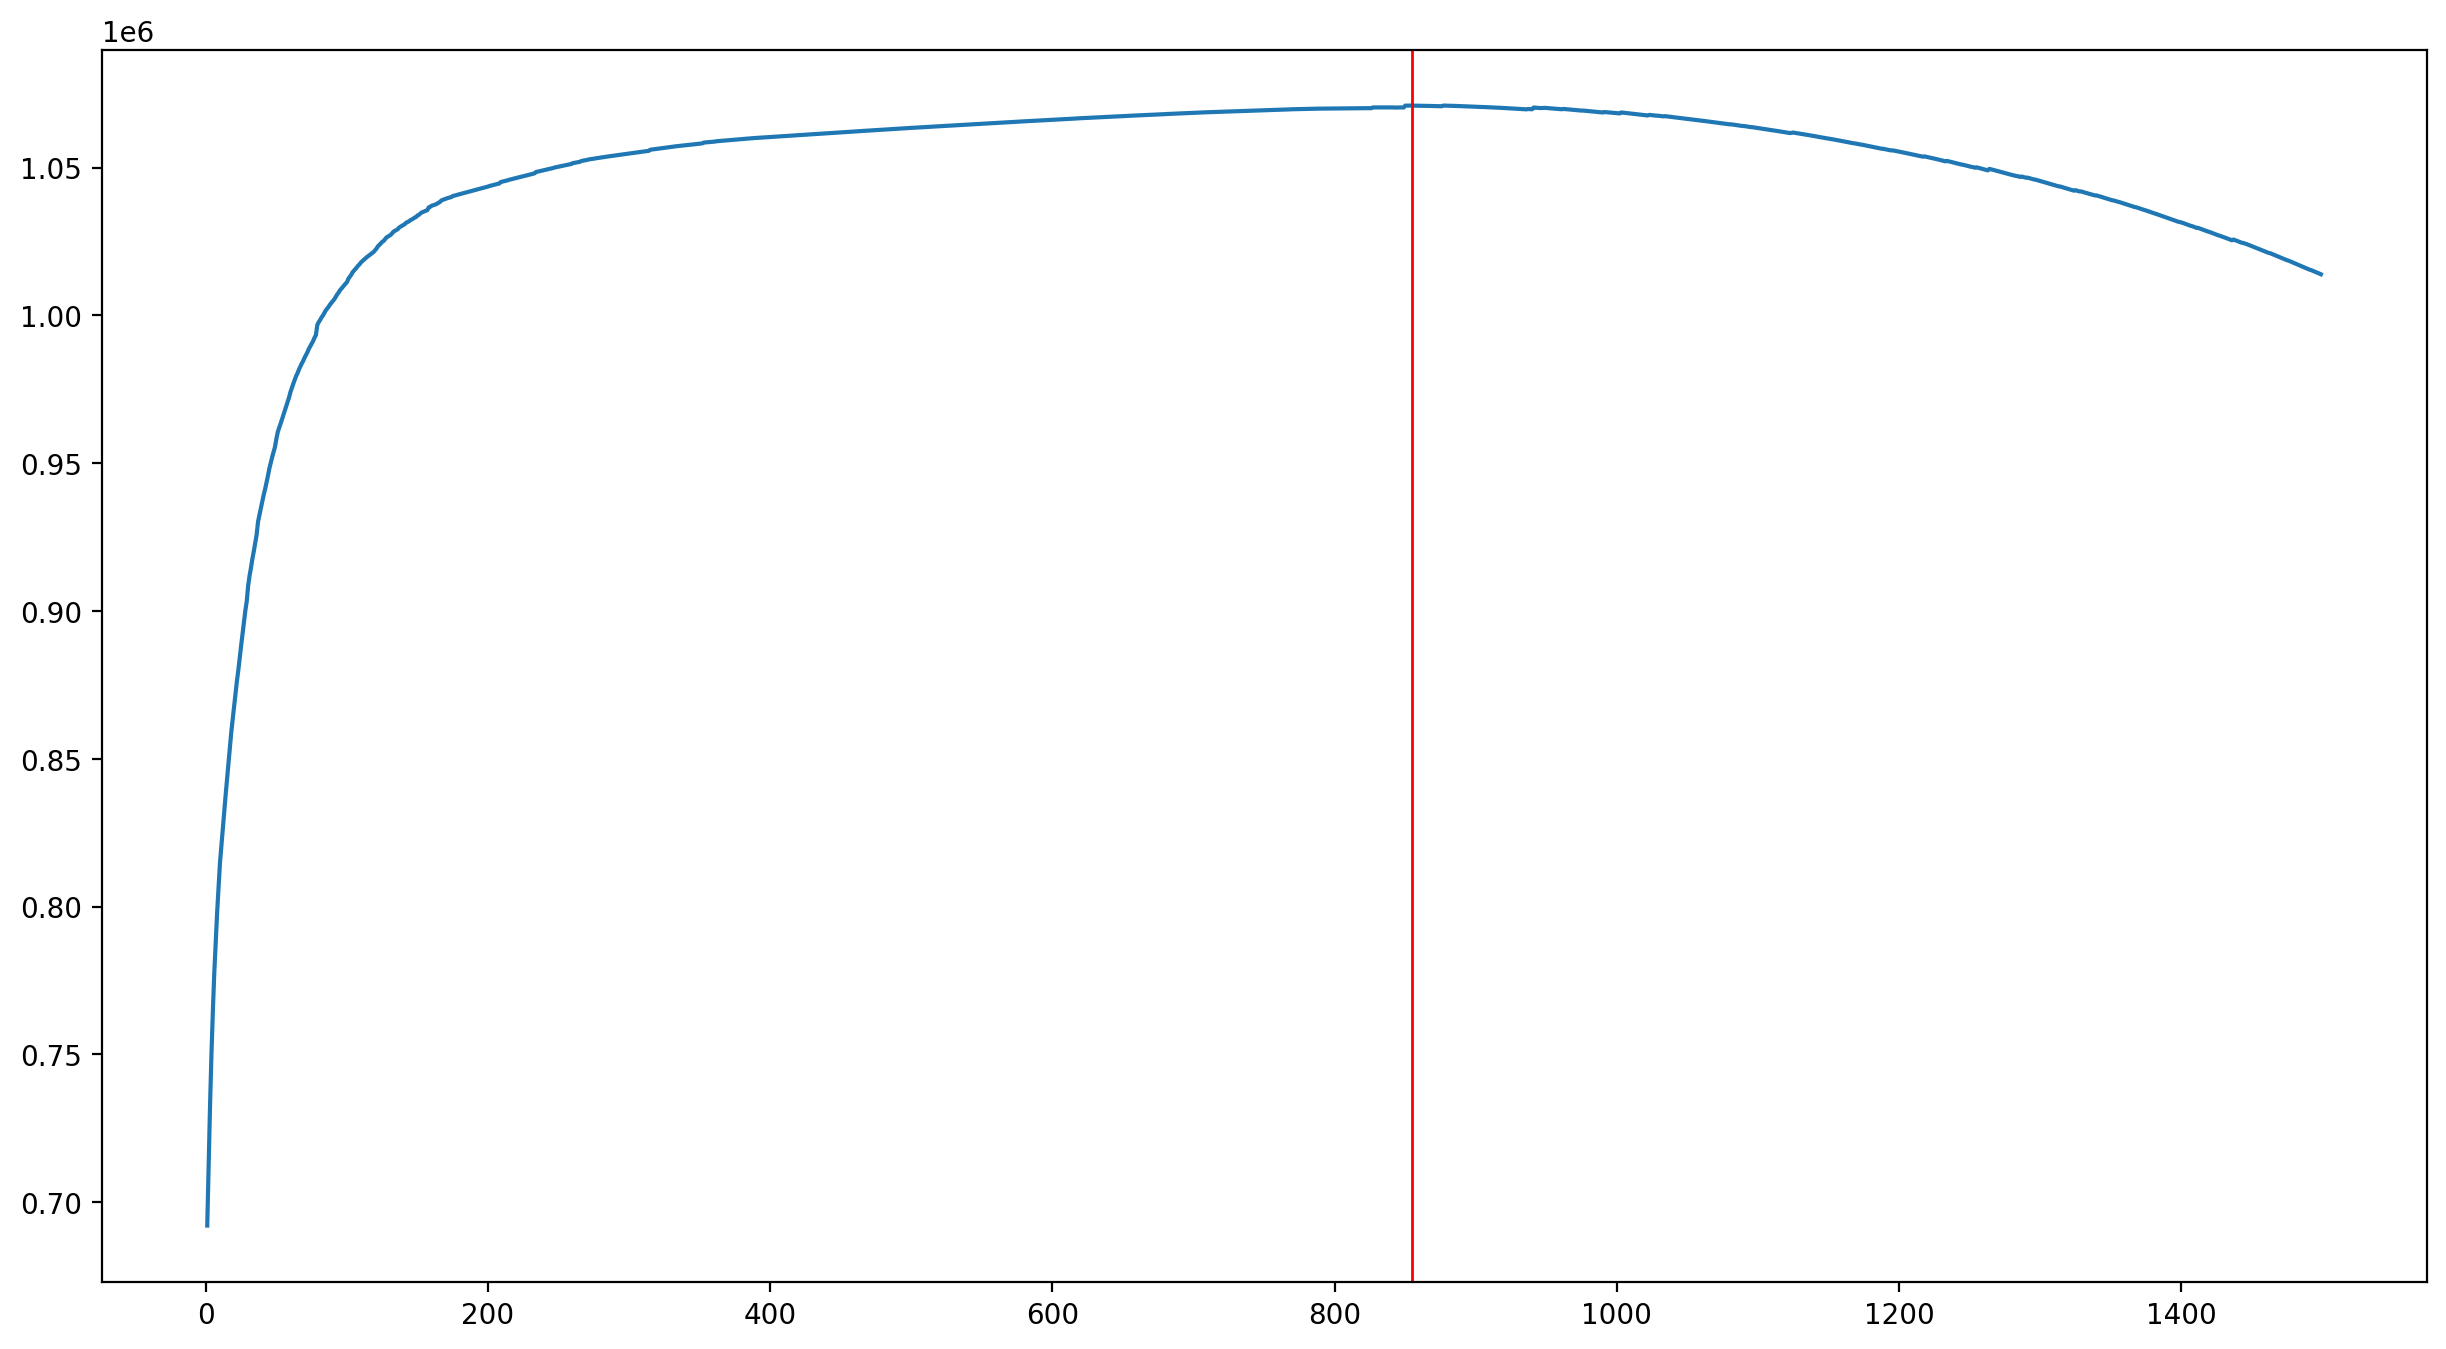

In [42]:
numbers_of_removals = np.arange(1, 1500)
profit_after_removal = [calculate_total_profits(least_profitable_sellers.iloc[i:, :]) for i in numbers_of_removals]

optimal_number_of_removals = numbers_of_removals[profit_after_removal.index(max(profit_after_removal))]

plt.figure(figsize=(15,8))
g = sns.lineplot(x=numbers_of_removals, y=profit_after_removal)
g.axvline(optimal_number_of_removals, color="red", linewidth=1);

In [16]:
increase_profit_optimal = max(profit_after_removal) - baseline_profit
# print(f"To maximize profit ({np.round(max(profit_after_removal)/1_000_000, 2)} mil), you should remove your {optimal_number_of_removals} worst sellers.")


print(f"By removing the {optimal_number_of_removals} worst sellers, we increase profit by {round(increase_profit_optimal/1000)}k")

By removing the 855 worst sellers, we increase profit by 403k


## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Removing Outliers

In [17]:
iqr = sellers["profits"].quantile(0.75) - sellers["profits"].quantile(0.25)
lower_bound = sellers["profits"].quantile(0.25) - 1.5 * iqr

outliers = sellers["profits"] < lower_bound

profit_without_outliers = calculate_total_profits(sellers[~outliers])

print(f"Removing the outliers ({sum(outliers)}), we increase profit by {round(profit_without_outliers - baseline_profit)/1000}k")

Removing the outliers (61), we increase profit by 307.95k


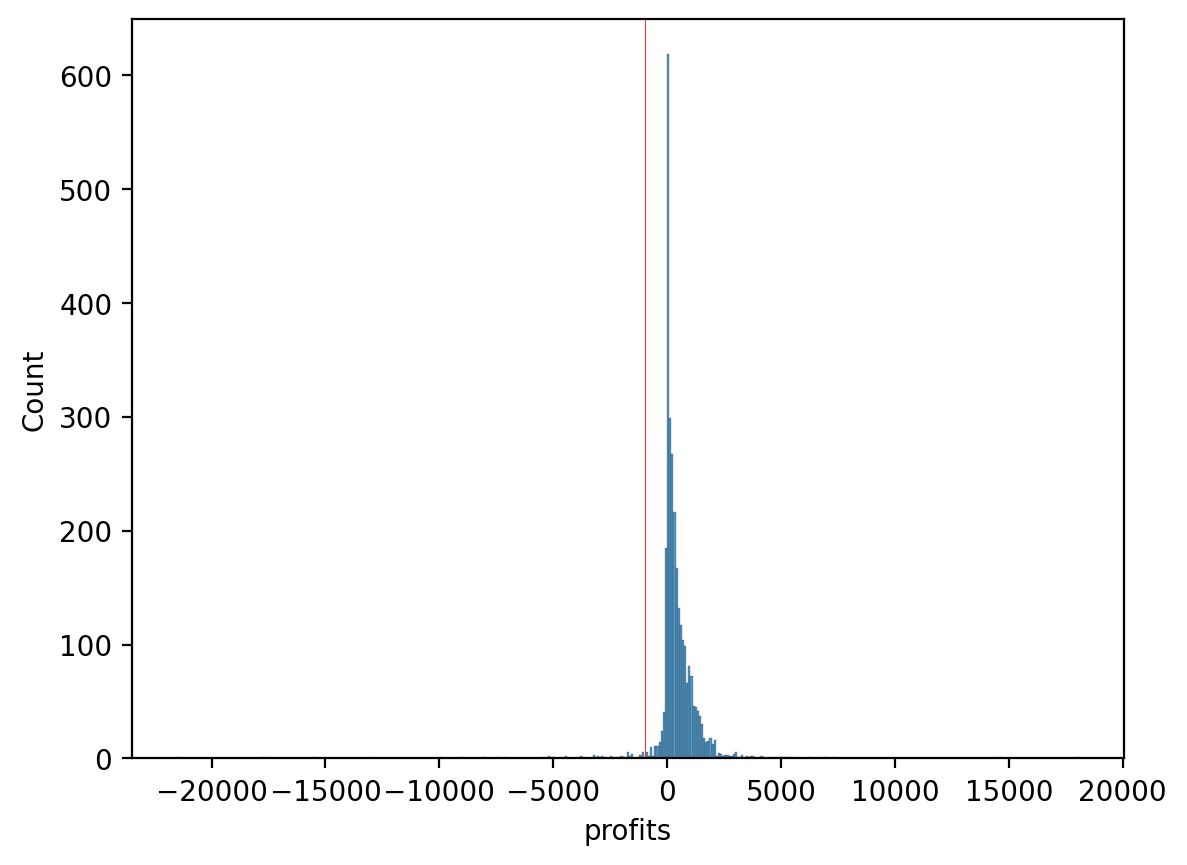

In [37]:
# plt.figure(figsize=(15,8))
g = sns.histplot(data=sellers, x="profits")
g.axvline(lower_bound, color="red", linewidth=0.3);

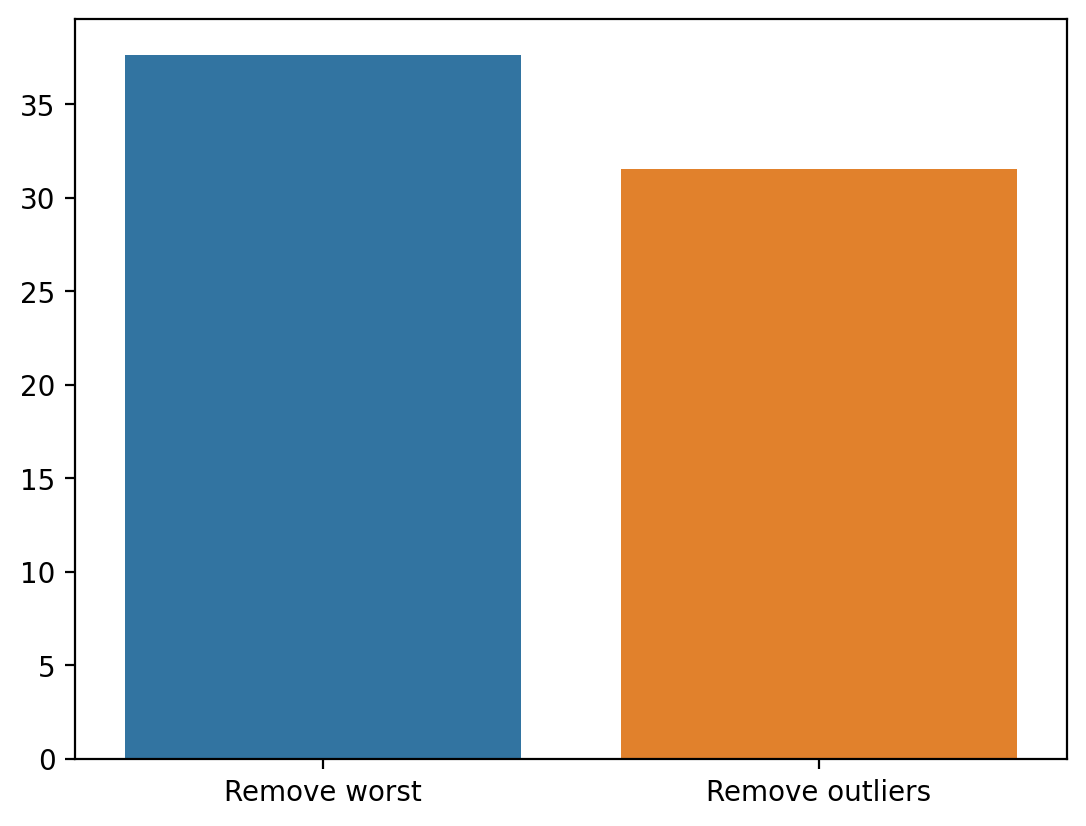

[37.66349076355024, 31.566496991585925]


In [44]:
increases = [(1- baseline_profit/max(profit_after_removal)) *100, (1 - baseline_profit/profit_without_outliers) *100]
g =sns.barplot(x=["Remove worst", "Remove outliers"], y=increases)
plt.show()
print(increases)

## Remove categories

In [ ]:
from olist.product import Product

products = Product().get_training_data()
products

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.000000,10.910000,0.000000,1.000000,5.000000,0,1,1,10.91,1.091,1.091
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,9.500000,16.900000,0.000000,0.500000,3.500000,50,2,2,33.80,3.380,-46.620
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.444444,325.627273,0.200000,0.400000,3.700000,240,10,11,3581.90,358.190,118.190
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.000000,399.900000,0.000000,0.000000,2.000000,50,1,1,399.90,39.990,-10.010
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.000000,137.900000,0.000000,1.000000,5.000000,0,1,1,137.90,13.790,13.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,13b25797ad1e6d6c7cd3cbeb35f8ee7a,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery,8.000000,129.900000,0.000000,0.000000,3.000000,40,1,1,129.90,12.990,-27.010
31480,dc36a7859b743d8610a2bbbaea26ece9,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery,6.000000,249.000000,0.000000,1.000000,5.000000,0,1,1,249.00,24.900,24.900
31481,107fde0930956120d1e13dd1062fbb46,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery,17.000000,399.990000,0.000000,0.000000,4.000000,0,1,1,399.99,39.999,39.999
31482,726b4e18f00255e2e63491bcba3f60b8,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery,11.818182,84.545455,0.136364,0.681818,4.272727,300,22,22,1860.00,186.000,-114.000


<AxesSubplot:xlabel='profits', ylabel='Count'>

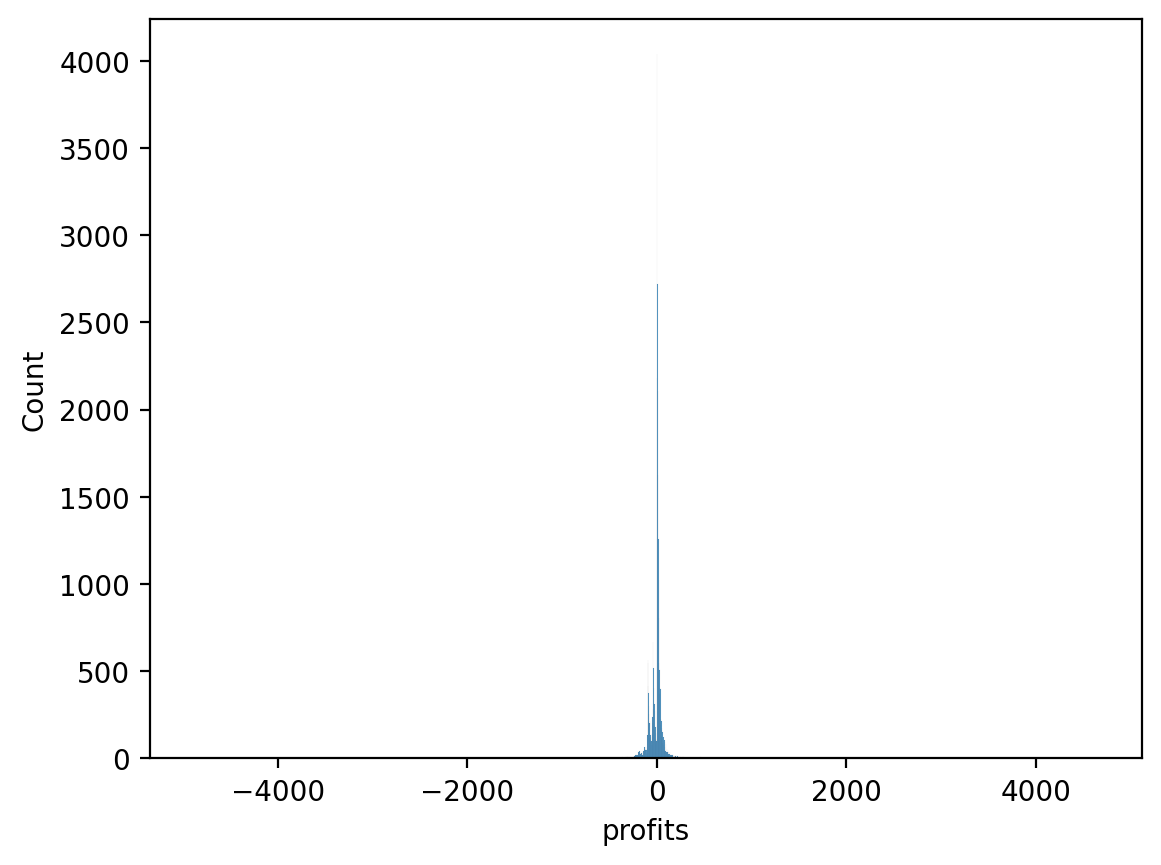

In [ ]:
sns.histplot(data=products, x="profits")

<AxesSubplot:xlabel='profits', ylabel='Count'>

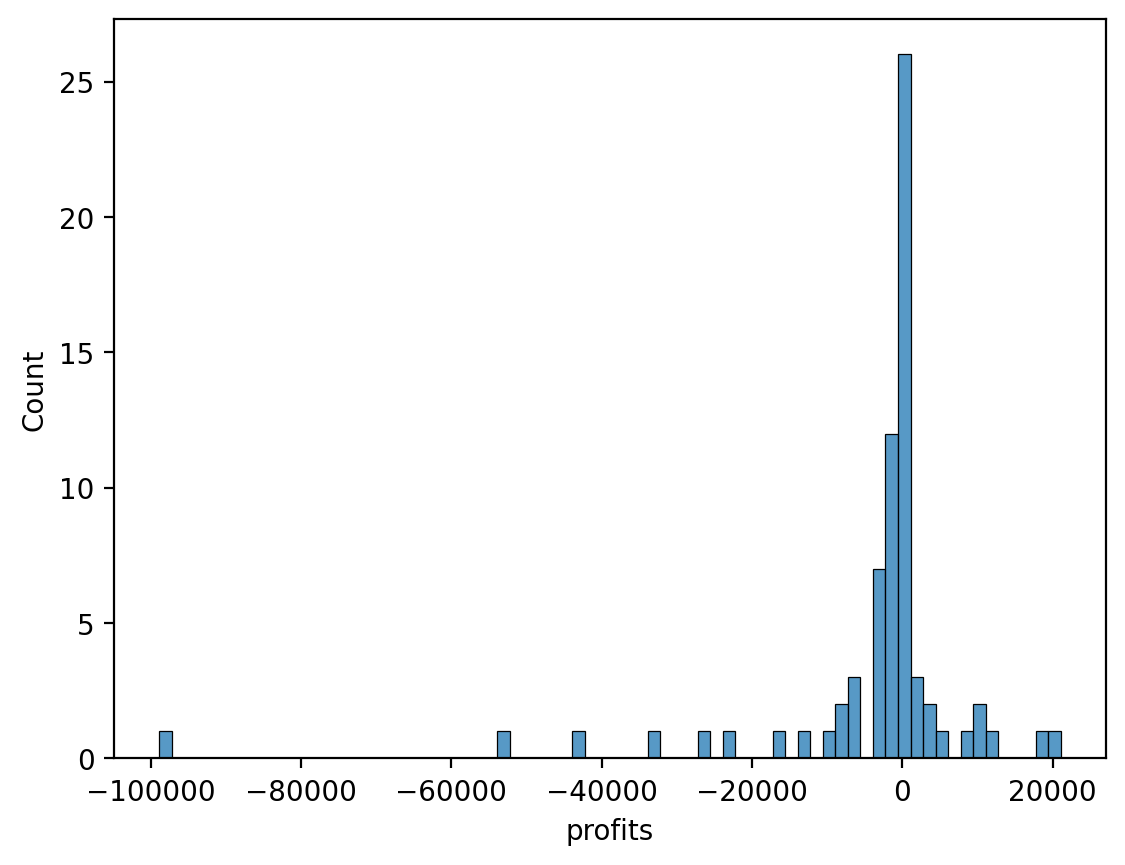

In [ ]:
sns.histplot(products.groupby("category")["profits"].sum().sort_values())

In [ ]:
worst_categories = list(products.groupby("category")["profits"].sum().sort_values().index)

In [ ]:
worst_categories

['bed_bath_table',
 'furniture_decor',
 'telephony',
 'computers_accessories',
 'housewares',
 'electronics',
 'sports_leisure',
 'fashion_bags_accessories',
 'baby',
 'perfumery',
 'toys',
 'office_furniture',
 'stationery',
 'garden_tools',
 'home_confort',
 'auto',
 'home_appliances',
 'health_beauty',
 'audio',
 'pet_shop',
 'food',
 'drinks',
 'fashion_male_clothing',
 'market_place',
 'consoles_games',
 'fashion_underwear_beach',
 'christmas_supplies',
 'art',
 'books_technical',
 'fashion_shoes',
 'costruction_tools_garden',
 'home_construction',
 'fashio_female_clothing',
 'home_comfort_2',
 'furniture_mattress_and_upholstery',
 'furniture_living_room',
 'diapers_and_hygiene',
 'food_drink',
 'dvds_blu_ray',
 'arts_and_craftmanship',
 'tablets_printing_image',
 'cine_photo',
 'party_supplies',
 'books_imported',
 'flowers',
 'fashion_sport',
 'signaling_and_security',
 'security_and_services',
 'la_cuisine',
 'cds_dvds_musicals',
 'music',
 'fashion_childrens_clothes',
 'books_

In [ ]:
from olist.data import Olist
order_items = Olist().get_data()["order_items"]

def num_seller_without_category(categories):
    return (products
            .merge(order_items, on="product_id", how="inner")[["product_id", "seller_id", "category", "profits"]]
            .loc[lambda _df: ~(_df["category"].isin(categories))]
            .seller_id.nunique()
    )


<AxesSubplot:>

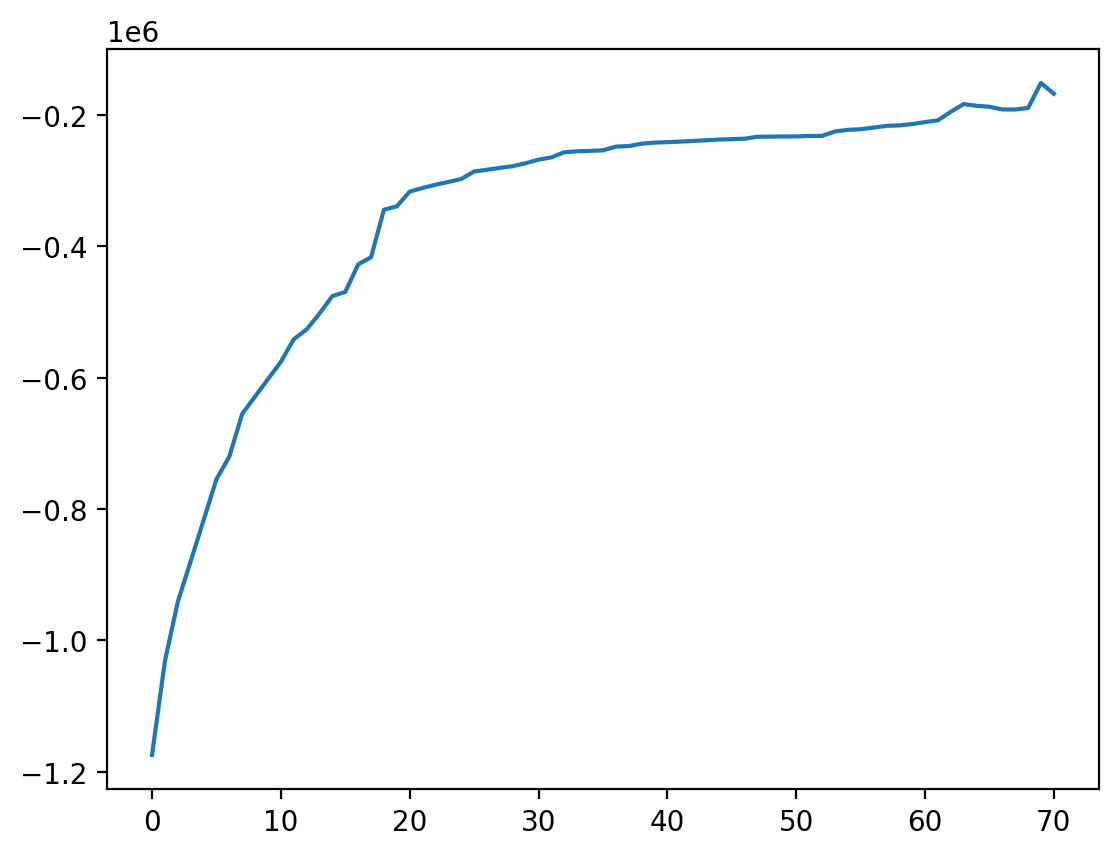

In [ ]:
n_categories_removed = np.arange(0, len(worst_categories))

def remove_n_categories(df, n):
    return df[~df["category"].isin(worst_categories[:n])]

profits_after_categories_removed = [calculate_total_profits(
                                        remove_n_categories(products, i)
                                        )
                                        for i in n_categories_removed]

sns.lineplot(x=n_categories_removed, y=profits_after_categories_removed)

In [ ]:
calculate_total_profits(products[products["category"] != "bed_bath_table"], len(sellers))

-670656.6504497826

In [ ]:
remove_n_categories(products, 1)


,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.000000,10.910000,0.000000,1.000000,5.000000,0,1,1,10.91,1.091,1.091
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,9.500000,16.900000,0.000000,0.500000,3.500000,50,2,2,33.80,3.380,-46.620
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.444444,325.627273,0.200000,0.400000,3.700000,240,10,11,3581.90,358.190,118.190
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.000000,399.900000,0.000000,0.000000,2.000000,50,1,1,399.90,39.990,-10.010
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.000000,137.900000,0.000000,1.000000,5.000000,0,1,1,137.90,13.790,13.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,13b25797ad1e6d6c7cd3cbeb35f8ee7a,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery,8.000000,129.900000,0.000000,0.000000,3.000000,40,1,1,129.90,12.990,-27.010
31480,dc36a7859b743d8610a2bbbaea26ece9,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery,6.000000,249.000000,0.000000,1.000000,5.000000,0,1,1,249.00,24.900,24.900
31481,107fde0930956120d1e13dd1062fbb46,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery,17.000000,399.990000,0.000000,0.000000,4.000000,0,1,1,399.99,39.999,39.999
31482,726b4e18f00255e2e63491bcba3f60b8,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery,11.818182,84.545455,0.136364,0.681818,4.272727,300,22,22,1860.00,186.000,-114.000


In [46]:
800/len(sellers)

0.2696326255476913

In [52]:
print(1 - least_profitable_sellers.iloc[793:, :].n_orders.sum()/sellers.n_orders.sum())
# print(least_profitable_sellers.iloc[793:, :].n_orders.sum())

0.40292064382367965


## Removing depending on time on olist and not turning profitable

(-2000.0, 2000.0)

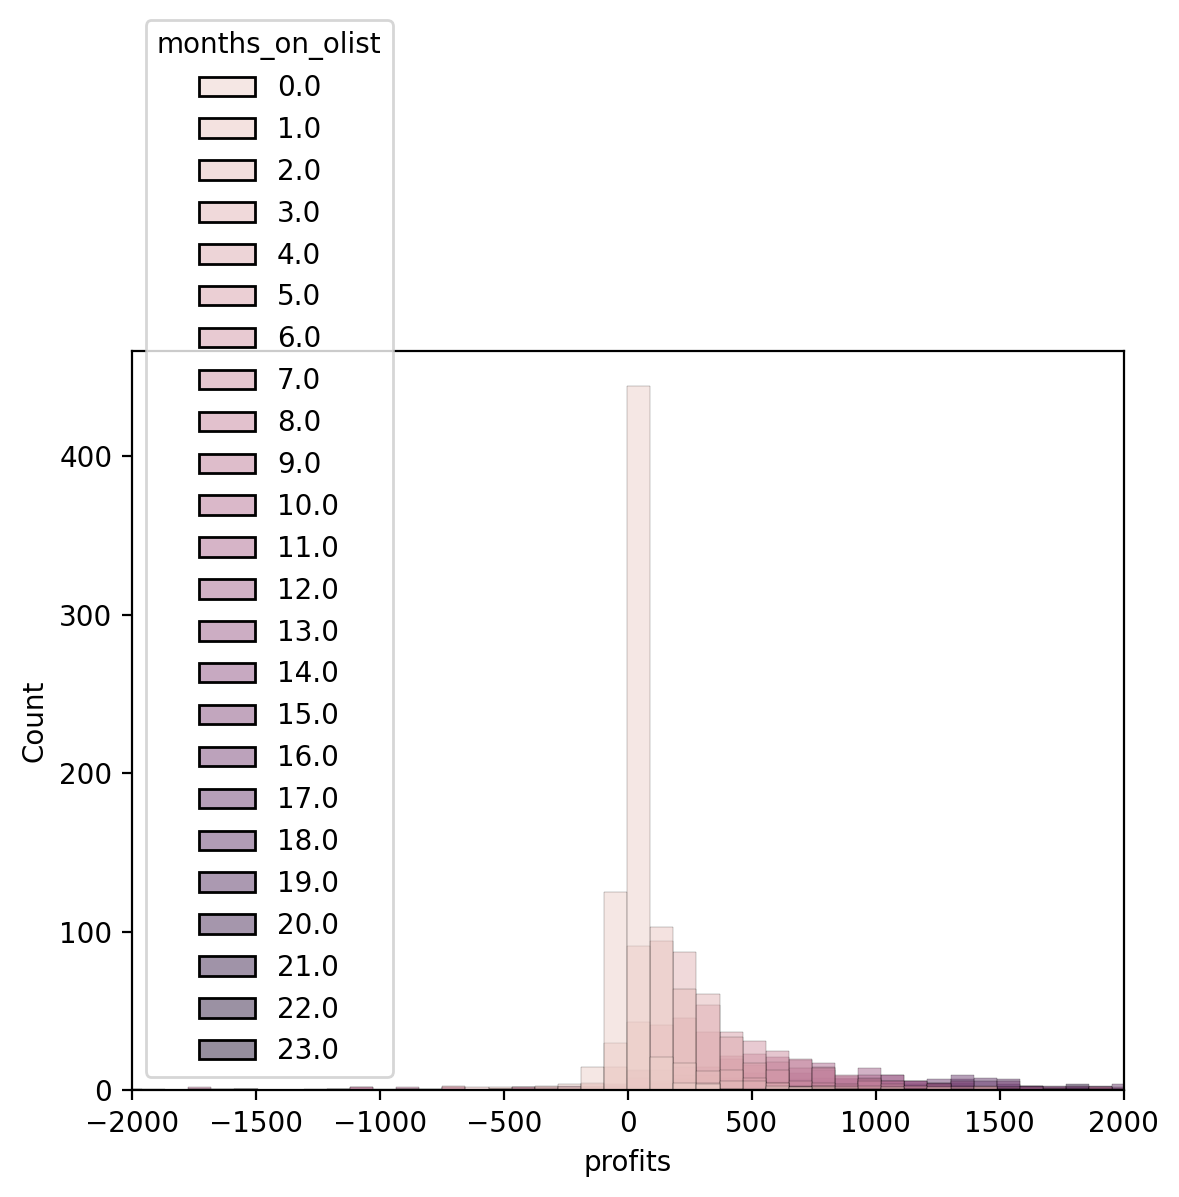

In [ ]:
import matplotlib as plt
g = sns.histplot(data=least_profitable_sellers, x="profits", hue="months_on_olist", legend=True)
g.set_xlim(-2000, 2000)
# g.set_ylim(200)

<AxesSubplot:xlabel='months_on_olist', ylabel='profits'>

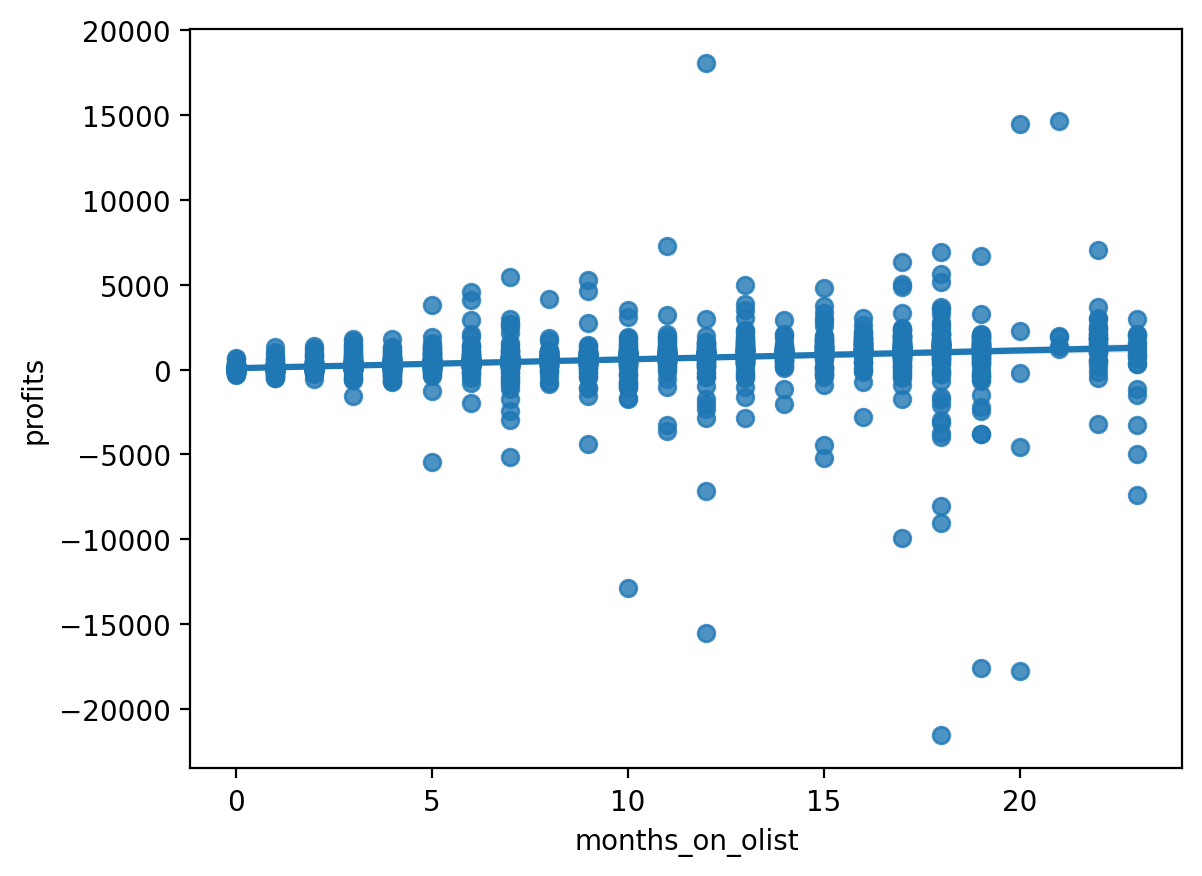

In [ ]:
sns.regplot(data=sellers, x="months_on_olist", y="profits")

In [ ]:
non_profits_after_12_m = (sellers["profits"] < 0) & (sellers["months_on_olist"] > 12)

# non_profits_after_12_m

profit_wo_non_profits_after_12_m = calculate_total_profits(sellers.loc[~non_profits_after_12_m,:])

print(f"Removing the ones who are not profitable after 12 months ({sum(non_profits_after_12_m)}), we increase profit by {round(profit_wo_non_profits_after_12_m - baseline_profit)/1000}k")

Removing the ones who are not profitable after 12 months (67), we increase profit by 227.587k


## Trying to find correlations

<AxesSubplot:>

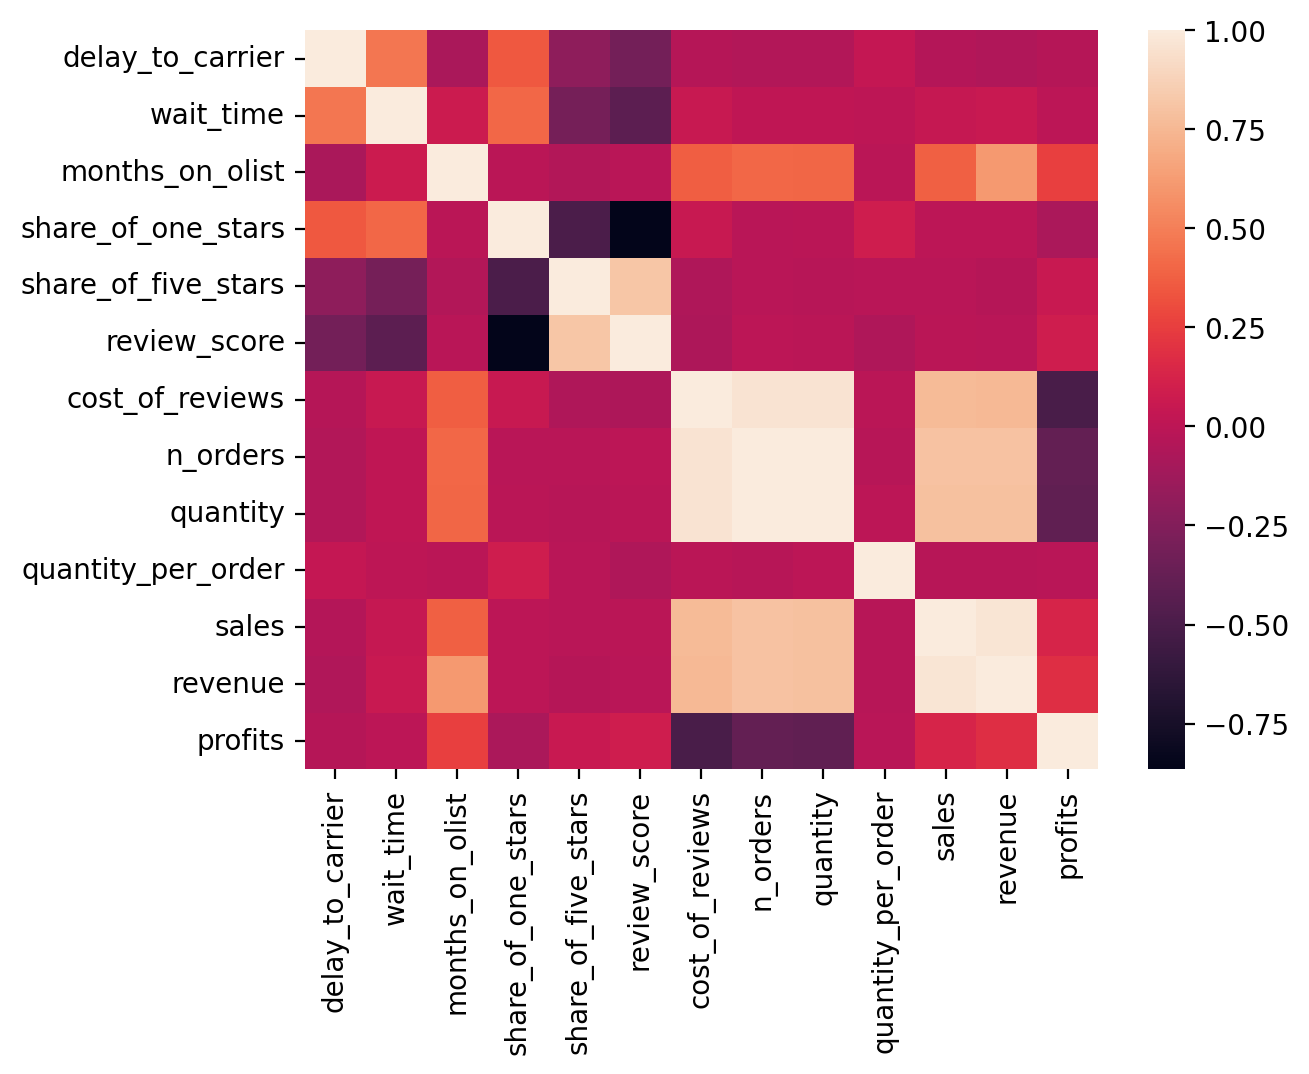

In [ ]:
sns.heatmap(sellers.corr())

## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪